In [ ]:
#Logistic Regression,

In [1]:
#导入包
from numpy import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
import scipy

In [2]:
def get_data(fileName):
    data = load_svmlight_file(fileName)
    return data[0],data[1]
x_train,y_train = get_data("a9a")
x_test,y_test = get_data("a9a.t")

In [3]:
m,n = x_train.shape
x = scipy.sparse.csr.csr_matrix(ones((m,n+1)))
x[:,1:n+1] = x_train
x_train = x
#print(x_test.shape)
#x_test少了一维特征
x = scipy.sparse.csr.csr_matrix(zeros((x_test.shape[0],n)))
print(n,x_train.shape)
x[:,:n-1] = x_test;
x_test = x
x = scipy.sparse.csr.csr_matrix(ones((x_test.shape[0],n+1)));x[:,1:n+1] = x_test;x_test = x

123 (32561, 124)


C:\Users\acer\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [128]:
#批量数量
batch = 5000

In [141]:
def loss(y,label):
    #print(y.shape)
    m = y.shape[0]
    '''
    sum_list = []
    a = 0
    for i in range(m):
        
        if label[i] == 0:
            a = -np.log(1-y[i])
        else:
            a = -np.log(y[i])
    sum_list.append(a)
    '''
    return sum(-label*np.log(y)- (1-label) * np.log(1-y))/m
    #return sum(sum_list)/m

In [133]:
def sigmoid(x,weights):
    #print(x.shape,weights.shape)
    return 1/(1+exp(-x*weights))

In [166]:
theta = 0.5#阈值
def SGD(weights,alpha,x,h,y,m,index):
     #SGD
    #index = random.randint(0,m)
    end = index + batch
    grad = (x[index:end,:].T * ( h[index:end,:] - y[:,index:end].T))/batch
    return grad
    #return weights - alpha * (x[index,:].T * ( h[index] - y[:,index]))/m

In [172]:
def NAG(weights,alpha,x,h,y,m,v,index):
    r = 0.9
    
    #w = weights - r * v
   
    #print(v)
     # theta(t) - r*v(t-1)
    #print(weights.shape,v.shape)
    #h_nag = sigmoid(x, weights)
    grad = SGD(weights,alpha,x,h,y,m,index)
    v = r*v + alpha*grad
    weights = weights - v
    
    return weights,v#,h_nag

In [155]:
def Adagrad(weights,alpha,x,h,y,m,G,index):
    
    grad = SGD(weights,alpha,x,h,y,m,index)
    G = G+multiply(grad,grad)
    ele = 1e-8
    weights = (weights  - multiply(alpha / sqrt(G + ele) , grad))
    return weights ,G

In [156]:
def RMSProp(weights,alpha,x,h,y,m,G,index):
    r = 0.9
    grad = SGD(weights,alpha,x,h,y,m,index)
    G = r*G + (1-r)*multiply(grad,grad)
    ele = 1e-8
    weights = (weights  - multiply(alpha / sqrt(G + ele) , grad))
    return weights ,G

In [157]:
def Adam(weights,x,h,y,m,G,moment,a,k,eta,index):
    #给各内部参数赋值
    #eta = 0.001
    r = 0.999
    b = 0.9
    ele = 1e-8
    
    grad = SGD(weights,eta,x,h,y,m,index)

    moment = b * moment + (1-b)*grad
    G = r*G + (1-r)*multiply(grad,grad)
    alpha = eta * sqrt(1- pow(r,k)) /(1 - pow(b,k))
    #print(pow(r,k))
    weights = weights - alpha * moment / sqrt(G+ele)
    
    return weights , G ,moment 

In [158]:
#计算准确率
def cul_accuracy(y,label):
    y[y>=0.5] = 1
    y[y< 0.5] = 0
    #print(y[0:20,:])
    n = label.shape[1]
    count = 0.0
    #print(n)
    for i in range(n):
        if(y[i,:] == label[:,i]):
            count +=1.0
    
    
    return (count/n)

In [174]:

def GD(x_train,y_train,x_test,y_test,alpha = 0.03 , max_iter = 1000):
    m,n = x_train.shape
    weights_nag = mat(zeros(n)).T
    weights_adagrad = mat(zeros(n)).T
    weights_RMSProp = mat(zeros(n)).T
    weights_adam = mat(zeros(n)).T
    iter_list = []
    train_list = []
    test_list = []
    y_train = mat(y_train)
    y_test = mat(y_test)
    #0为负类，1为正类
    y_train[y_train < 0 ] = 0
    y_test [y_test < 0 ] = 0
    #训练损失值
    train_adagrad = []
    train_nag =[]
    train_RMSProp = []
    train_adam =[]
    
    #准确度
    acc_nag     = []
    acc_adagrad =[]
    acc_RMSProp = []
    acc_adam    = []
    
    
    G = weights_nag.copy()
    G_RMSProp = weights_nag.copy()
    G_adam = weights_nag.copy()
    v = weights_nag.copy()
    moment = weights_nag.copy()
   
    h_adagrad = sigmoid(x_train,weights_adagrad)
    h_nag = sigmoid(x_train,weights_nag)
    h_RMSProp = sigmoid(x_train,weights_RMSProp)
    h_adam = sigmoid(x_train,weights_adam)
    
    alpha_adam = alpha
    for k in range(max_iter):
        #print(x.shape,weights.shape)
        print(k)#,"w",weights.shape,"x",x_train.shape)

       
        
        
        #确定随机数
        index = random.randint(0,m-batch)
        #更新v,G,moment等系数
        #NAG
        weights_nag,v= NAG(weights_nag,alpha,x_train,h_nag,y_train,m,v,index)
        
        #Adagrad
        weights_adagrad,G = Adagrad(weights_adagrad,alpha,x_train,h_adagrad,y_train,m,G,index)
        
        #RMS
        
        #print(weights_RMSProp.shape,h_RMSProp.shape)
        weights_RMSProp,G_RMSProp =  \
                RMSProp(weights_RMSProp,alpha,x_train,h_RMSProp,y_train,m,G_RMSProp,index)
            
        #Adam
        #print(weights_adam.shape,h_adam.shape)
        weights_adam,G_adam,moment = \
                Adam(weights_adam,x_train,h_adam,y_train,m,G_adam,moment,alpha_adam,k+1,alpha,index)
        
        #print(weights_nag.shape,weights_adagrad.shape)
        h_nag = sigmoid(x_train,weights_nag-v)
        h_adagrad = sigmoid(x_train,weights_adagrad)
        h_RMSProp = sigmoid(x_train,weights_RMSProp)
        h_adam = sigmoid(x_train,weights_adam)
        
        
        nag_loss = loss(h_nag,y_train)
        adagrad_loss = loss(h_adagrad,y_train)
        RMS_loss = loss(h_RMSProp,y_train)
        adam_loss = loss(h_adam,y_train)
        
        #添加进损失集合
        iter_list.append(k)
        train_nag.append(nag_loss)
        train_adagrad.append(adagrad_loss)
        train_RMSProp.append(RMS_loss)
        train_adam.append(adam_loss)
        
        #添加进准确率集合
        #acc_nag.append(cul_accuracy(h_nag,y_train))
        #acc_adagrad.append(cul_accuracy(h_adagrad,y_train))
        #acc_RMSProp.append(cul_accuracy(h_RMSProp,y_train))
        #acc_adam.append(cul_accuracy(h_adam,y_train))
        
    return iter_list ,train_nag , train_adagrad,train_RMSProp,train_adam,acc_nag,acc_adagrad, acc_RMSProp, acc_adam

In [180]:
iter_list ,train_nag , train_adagrad,train_RMSProp,train_adam,acc_nag,  acc_adagrad, acc_RMSProp, acc_adam =  \
                    GD(x_train, y_train,x_test,y_test,alpha = 0.01, max_iter = 1000) 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

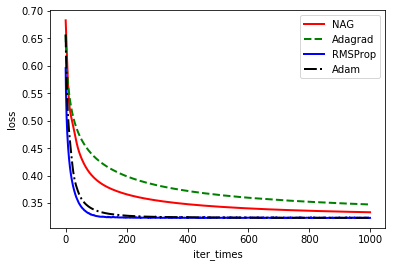

In [182]:

plt.figure()
plt.plot(iter_list,train_nag,color = 'red',linewidth = 2.0,label = 'NAG')
plt.plot(iter_list,train_adagrad,linestyle = '--',color = 'green',linewidth = 2.0 , label = 'Adagrad')
plt.plot(iter_list,train_RMSProp,linestyle = '-',color = 'blue',linewidth = 2.0 , label = 'RMSProp')
plt.plot(iter_list,train_adam,linestyle = '-.',color = 'black',linewidth = 2.0, label = 'Adam')
plt.xlabel('iter_times')  
plt.ylabel('loss')
plt.legend()
plt.show()
#SGD results in a shunk

In [90]:
train_nag

[0.69314718055994629,
 0.65607246120665186,
 0.60420817771726365,
 0.56720504459581655,
 0.55083194987189688,
 0.55812051051960798,
 0.58021674299699999,
 0.60750235885297965,
 0.64586469923024914,
 0.67733492401024298,
 0.69700424175588505,
 0.71894625888645458,
 0.74198534910354541,
 0.73210753577673249,
 0.72640742194974983,
 0.72325081436117633,
 0.70556032778888744,
 0.69123089371926394,
 0.68128935163800863,
 0.64257487131173019]